## **OKCupid Date-a-Scientist**

### Scope

In recent years, there has been a massive rise in the usage of dating apps to find love. Many of these apps use sophisticated data science techniques to recommend possible matches to users and to optimize the user experience. These apps give us access to a wealth of information that we’ve never had before about how different people experience romance.

The focus of this project is predicting the zodiac sign of the users. Zodiac symbols are important for many users, but some users don’t add them in. This way, we can predict a user’s zodiac signs so we can guess the missing zodiacs when we make matches.

### Introduction

First, necessary libraries are imported and the data is loaded and previewed.

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from preprocessing import preprocess_text

df = pd.read_csv('profiles.csv')
df.head()

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,...,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...",...,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,...,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,38,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,...,"san francisco, california",NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available
3,23,thin,vegetarian,socially,NaN,working on college/university,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,...,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single
4,29,athletic,NaN,socially,never,graduated from college/university,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at:<br />\nhttp://bag...,i smile a lot and my inquisitive nature,...,"san francisco, california",NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single


We can see that there are some essay questions that are more suitable for NLP approach and modeling. We will separate these questions to another data frame and return to it later.

In [16]:
# df_essay = pd.concat([df.loc[:,'essay0':'essay9'],df.sign],axis = 1)
# df.drop(columns = df.loc[:,'essay0':'essay9'].columns, inplace = True)

Next, we can have a look at the basic information and missing values.

In [17]:
df.drop(columns = df.loc[:,'essay0':'essay9'].columns).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          59946 non-null  int64  
 1   body_type    54650 non-null  object 
 2   diet         35551 non-null  object 
 3   drinks       56961 non-null  object 
 4   drugs        45866 non-null  object 
 5   education    53318 non-null  object 
 6   ethnicity    54266 non-null  object 
 7   height       59943 non-null  float64
 8   income       59946 non-null  int64  
 9   job          51748 non-null  object 
 10  last_online  59946 non-null  object 
 11  location     59946 non-null  object 
 12  offspring    24385 non-null  object 
 13  orientation  59946 non-null  object 
 14  pets         40025 non-null  object 
 15  religion     39720 non-null  object 
 16  sex          59946 non-null  object 
 17  sign         48890 non-null  object 
 18  smokes       54434 non-null  object 
 19  spea

### Data Cleaning

Now, we can inspect some columns that may have a majority of `NaN` or not specified values (like `income` and `offspring`). In order to clean up the data, we can remove these columns along with the columns that may not be important for predicting the zodiac sign.

In [18]:
# print(df.offspring.value_counts(dropna = False))
# print(df.income.value_counts(dropna = False))
# print(df.offspring.value_counts(dropna = False))

df.drop(columns = ['income','offspring','age','ethnicity','height','last_online','location','speaks'], inplace = True)
df

,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,...,essay8,essay9,job,orientation,pets,religion,sex,sign,smokes,status
0,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...","books:<br />\nabsurdistan, the republic, of mi...",...,i am new to california and looking for someone...,you want to be swept off your feet!<br />\nyou...,transportation,straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,single
1,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,...,i am very open and will share just about anyth...,NaN,hospitality / travel,straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,single
2,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ...",NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,available
3,thin,vegetarian,socially,NaN,working on college/university,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . .<br />\nlynch, j...",...,NaN,you feel so inclined.,student,straight,likes cats,NaN,m,pisces,no,single
4,athletic,NaN,socially,never,graduated from college/university,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at:<br />\nhttp://bag...,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians<br />\nat the...",...,NaN,NaN,artistic / musical / writer,straight,likes dogs and likes cats,NaN,m,aquarius,no,single
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,NaN,NaN,socially,never,graduated from college/university,"vibrant, expressive, caring optimist. i love b...",the happiest times have been when life came to...,i make an outstanding osso bucco. i am also ve...,"i am told that people notice my smile, eyes an...",i am an avid movie watcher and follow the broa...,...,i have a dream to sing at the alconquin in nyc...,you are seeking a long term connection of shar...,sales / marketing / biz dev,straight,has dogs,catholicism but not too serious about it,f,cancer and it&rsquo;s fun to think about,no,single
59942,fit,mostly anything,often,sometimes,working on college/university,i'm nick.<br />\ni never know what to write ab...,currently finishing school for film production...,"<a class=""ilink"" href=""/interests?i=filmmaking...","dude, i don't know.",<strong>movies</strong>:<br />\nhook (the grea...,...,when i was 18 i got a tattoo of waldo somewher...,meh if you made it this far you might as well.,entertainment / media,straight,likes dogs and likes cats,agnosticism,m,leo but it doesn&rsquo;t matter,no,single
59943,average,mostly anything,not at all,never,graduated from masters program,"hello! i enjoy traveling, watching movies, and...","i'm a civil engineer, who enjoys helping the c...",- looking at things objectively<br />\n- getti...,i'm quiet until i get used to the environment ...,"last book: ""game change"".<br />\nmovies: bourn...",...,please let me think about this more.,we have similar interests.,construction / craftsmanship,straight,NaN,christianity

We can see that `sign` and `religion` have pretty messy values. We can separate the religion/sign into one column and the rest in the second. Also, we have to fill the `NaN` values for the comments that were not inputted.

In [19]:
# replacing the html special characters for colon
df['sign'] = df.sign.replace({'&rsquo;':'\''},regex = True)

# splitting the sign column
df['zodiac'] = df.sign.str.split(' ').str.get(0)
df['zodiac_comment'] = df.sign.str.split(' ',1).str.get(1)
df['zodiac_comment'] = df['zodiac_comment'].fillna('None') 

# splitting the religion column
df['religion_comment'] = df.religion.str.split(' ',1).str.get(1)
df['religion'] = df.religion.str.split(' ').str.get(0)
df['religion_comment'] = df['religion_comment'].fillna('None') 

df.drop(columns=['sign'],inplace = True)
print(df.zodiac.value_counts())
df

leo            4374
gemini         4310
libra          4207
cancer         4206
virgo          4141
taurus         4140
scorpio        4134
aries          3989
pisces         3946
sagittarius    3942
aquarius       3928
capricorn      3573
Name: zodiac, dtype: int64


,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,...,job,orientation,pets,religion,sex,smokes,status,zodiac,zodiac_comment,religion_comment
0,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...","books:<br />\nabsurdistan, the republic, of mi...",...,transportation,straight,likes dogs and likes cats,agnosticism,m,sometimes,single,gemini,None,and very serious about it
1,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,...,hospitality / travel,straight,likes dogs and likes cats,agnosticism,m,no,single,cancer,None,but not too serious about it
2,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,...,NaN,straight,has cats,NaN,m,no,available,pisces,but it doesn't matter,None
3,thin,vegetarian,socially,NaN,working on college/university,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . .<br />\nlynch, j...",...,student,straight,likes cats,NaN,m,no,single,pisces,None,None
4,athletic,NaN,socially,never,graduated from college/university,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at:<br />\nhttp://bag...,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians<br />\nat the...",...,artistic / musical / writer,straight,likes dogs and likes cats,NaN,m,no,single,aquarius,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,NaN,NaN,socially,never,graduated from college/university,"vibrant, expressive, caring optimist. i love b...",the happiest times have been when life came to...,i make an outstanding osso bucco. i am also ve...,"i am told that people notice my smile, eyes an...",i am an avid movie watcher and follow the broa...,...,sales / marketing / biz dev,straight,has dogs,catholicism,f,no,single,cancer,and it's fun to think about,but not too serious about it
59942,fit,mostly anything,often,sometimes,working on college/university,i'm nick.<br />\ni never know what to write ab...,currently finishing school for film production...,"<a class=""ilink"" href=""/interests?i=filmmaking...","dude, i don't know.",<strong>movies</strong>:<br />\nhook (the grea...,...,entertainment / media,straight,likes dogs and likes cats,agnosticism,m,no,single,leo,but it doesn't matter,None
59943,average,mostly anything,not at all,never,graduated from masters program,"hello! i enjoy traveling, watching movies, and...","i'm a civil engineer, who enjoys helping the c...",- looking at things objectively<br />\n- getti...,i'm quiet until i get used to the environment ...,"last book: ""game change"".<br />\nmovies: bourn...",...,construction / craftsmanship,straight,NaN,christianity,m,no,single,sagittarius,but it doesn't matter,but not too serious about it
59944,athletic,mostly anything,socially,often,working on college/university,"""all i have in this world are my balls and my ...","following my dreams...<br />\n""you got a dream...",listening,it used to be the hair until i mowed it off bu...,where to begin musically: right now i listen t...,...,medicine / health,straight,likes dogs and likes cats,agnosticism,m,trying to quit,single,leo,and it's fun to think about,but not too serious

In [20]:
# df_essay = pd.concat([df.loc[:,'essay0':'essay9'],df.zodiac],axis = 1)
# df.drop(columns = df.loc[:,'essay0':'essay9'].columns, inplace = True)

### **Exploratory Data Analisys**

As we cleaned the two categories above, we can see that there are only 12 zodiac signs and certain religions. Also, zodiac signs are distributed evenly.
Next, we can show the variation in sex across different categorical variables. The fields `education` and `job` have too many distinct variables and are therefore not plotted. As we can see, some variables like `drinks`, `drugs`, `smokes` etc. are ordinal variables nd will later be mapped to integer values.

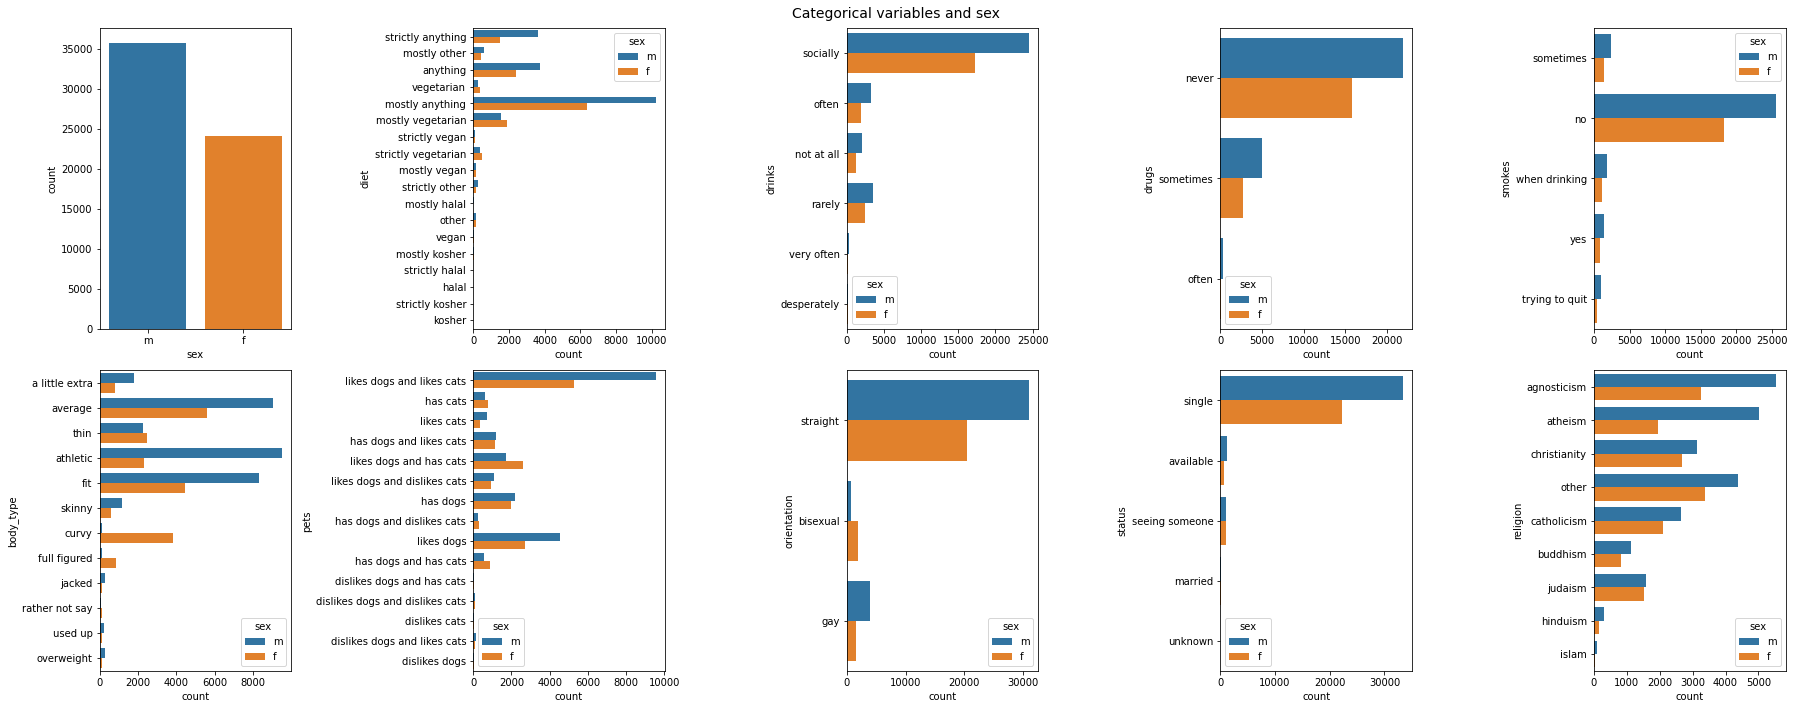

In [21]:
fig,axes=plt.subplots(2,5,figsize=(25,10))

sns.countplot(data = df, x ='sex',ax=axes[0,0])
sns.countplot(y="diet",hue="sex",data=df,ax=axes[0,1])
sns.countplot(y="drinks",data=df, hue = 'sex',ax=axes[0,2])
sns.countplot(y="drugs",hue="sex",data=df,ax=axes[0,3])
sns.countplot(y="smokes",hue="sex",data=df,ax=axes[0,4])

sns.countplot(y="body_type",hue="sex",data=df,ax=axes[1,0])
sns.countplot(y="pets",hue="sex",data=df,ax=axes[1,1])
sns.countplot(y="orientation",data=df, hue = 'sex',ax=axes[1,2])
sns.countplot(y="status",hue="sex",data=df,ax=axes[1,3])
sns.countplot(y="religion",hue="sex",data=df,ax=axes[1,4])

plt.suptitle("Categorical variables and sex",fontsize=14)
plt.tight_layout()

# print(df.job.value_counts())
# print(df.education.value_counts())

### **Data Preprocessing**

Now, we can start with the data preprocessing. First, we can map the certain columns like `drinks` and `drugs` to integers.

In [22]:
df['drinks'] = df.drinks.replace({'not at all':0,'rarely':1,'socially':2, 'often':3,'very often':4,'desperately':5})
df['drugs'] = df.drugs.replace({'never':0,'sometimes':1,'often':2})
df['smokes'] = df.smokes.replace({'no':0, 'trying to quit':1, 'when drinking':2,'sometimes':3, 'yes':4})

print(df.drugs.value_counts())
print(df.smokes.value_counts())

0.0    37724
1.0     7732
2.0      410
Name: drugs, dtype: int64
0.0    43896
3.0     3787
2.0     3040
4.0     2231
1.0     1480
Name: smokes, dtype: int64


<AxesSubplot:>

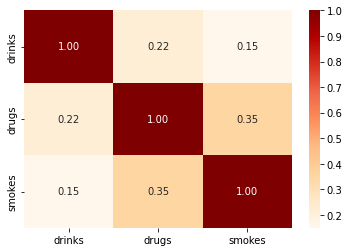

In [23]:
sns.heatmap(df.corr(),cmap='OrRd',annot=True,fmt=".2f")

In [24]:
df.dropna(inplace = True)

### Missing Values

In [25]:
# null_df = df.isnull().sum().sort_values(ascending=False).reset_index().rename(columns={'index':'feature', 0:'count'})
# null_df['percentage'] = null_df.apply(lambda row: row['count']/len(df), axis=1)
# null_df

### Select features, split and standardize data

In [26]:

# Select the desired features
features = df[['smokes','drinks',\
                    # 'body_type',\
                    # 'religion',\
                    # 'job',\
                    # 'education',\
                    # 'pets',\
                    # 'orientation',\
                    # 'diet',\
                    'drugs']]
zodiac = df.zodiac
# add essay questions
features = pd.concat([features,df.loc[:,'essay0':'essay9']],axis = 1)

features.dropna(inplace = True)
# features.loc[:,'essay0':'essay9'] = features.loc[:,'essay0':'essay9'].astype(str)


# Perform train and test split
X_train, X_test,y_train, y_test = train_test_split(features,zodiac, test_size = 0.2)

training_labels = y_train

X_train.loc[:,'essay0':'essay9'] = X_train.loc[:,'essay0':'essay9'].applymap(lambda x: preprocess_text(x))
# X_train.info()


# Scale the feature data so it has mean = 0 and standard deviation = 1
# stdScaler = StandardScaler()
# X_train_std = stdScaler.fit_transform(X_train)
# X_test_std = stdScaler.transform(X_test)

KeyError: 5

In [41]:
from scipy.sparse import hstack

training_data = None
test_data = None

print(X_train.shape)


for feature_colunm_name in list(X_train.loc[:,'essay0':'essay9'].columns):
    cv = CountVectorizer(stop_words = 'english')
    X_train_cv = cv.fit_transform(X_train[feature_colunm_name])

    # Merge the vector with others
    training_data = hstack((training_data, X_train_cv)) if training_data is not None else X_train_cv

    # Now transform the test data
    X_test_cv = cv.transform(X_test[feature_colunm_name])
    test_data = hstack((test_data, X_test_cv)) if test_data is not None else X_test_cv
    
print(training_data.shape)

# other columns
print(X_train[['smokes','drinks','drugs']].shape)

training_data = hstack([training_data, X_train[['smokes','drinks','drugs']].values]) 
print(training_data.shape)
test_data = hstack([test_data, X_test[['smokes','drinks','drugs']].values]) 

# Naive Bayes Classifier
zodiac_classifier = MultinomialNB()

zodiac_classifier.fit(training_data, training_labels)

predictions = zodiac_classifier.predict(test_data)
print(predictions)
print(f'Naive Bayes model score: {zodiac_classifier.score(test_data,y_test)}')

(6176, 13)
(6176, 152508)
(6176, 3)
(6176, 152511)
['cancer' 'cancer' 'cancer' ... 'cancer' 'gemini' 'virgo']
Naive Bayes model score: 0.09585492227979274


In [14]:
training_data = None
test_data = None

print(X_train.shape)
# training_labels = training_labels.head(50)
# X_train = X_train.head(50)

for column in list(X_train.loc[:,'essay0':'essay9'].columns):
# bag of words
    cv = CountVectorizer(stop_words = 'english')
    training_vector = pd.DataFrame(cv.fit_transform(X_train[column]).todense(),columns=cv.get_feature_names_out())
    test_vector = pd.DataFrame(cv.transform(X_test[column]).todense(),columns=cv.get_feature_names_out())

    training_data = pd.concat([training_data,training_vector],axis = 1) if training_data is not None else training_vector
    test_data = pd.concat([test_data,test_vector],axis = 1) if test_data is not None else test_vector

training_data.index = X_train.index
test_data.index = X_test.index
print(training_data.shape)

# other columns
print(X_train[['smokes','drinks','drugs']].shape)


training_data = pd.concat([training_data, X_train[['smokes','drinks','drugs']]],axis = 1) 
print(training_data.shape)
test_data = pd.concat([test_data, X_test[['smokes','drinks','drugs']]],axis = 1) 

# Naive Bayes Classifier
zodiac_classifier = MultinomialNB()

zodiac_classifier.fit(training_data, training_labels)

predictions = zodiac_classifier.predict(test_data)
print(predictions)
print(f'Naive Bayes model score: {zodiac_classifier.score(test_data,y_test)}')

(6176, 13)
(6176, 153681)
(6176, 3)
(6176, 153684)


MemoryError: Unable to allocate 7.07 GiB for an array with shape (153681, 6176) and data type int64

Label encoder

### **Machine Learning Models**

We can test various models and compare the results for the same set of data.

#### Logistic Regression

In [ ]:
# Create and train the model
LRmodel = LogisticRegression() 
LRmodel.fit(X_train_std,y_train)

# Analyze the coefficients
print('Coefficients:')
print(list(zip(features,LRmodel.coef_[0])))

# Score the model on the test data
print(f'Logistic Regression model score: {LRmodel.score(X_test_std,y_test)}')

Coefficients:
[('smokes', 0.002708843399374174), ('drinks', -0.0036302750174065455), ('drugs', 0.04420630705276369)]
Logistic Regression model score: 0.08610332398878655


#### K-Neighbors Classifier

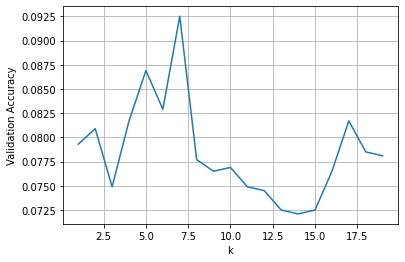

K-Neighbors model score: 0.08530236283540249


In [ ]:
# choose the best value of k
accuracies = []
i = 20
for k in range(1,i):
  classifier = KNeighborsClassifier(k)
  classifier.fit(X_train_std,y_train)
  accuracies.append(classifier.score(X_test_std,y_test))
klist = range(1,i)

plt.plot(klist,accuracies)
plt.xlabel('k')
plt.ylabel('Validation Accuracy')
plt.grid()
plt.show()

k = 10

# fit the model
model2 = KNeighborsClassifier(k)
model2.fit(X_train,y_train)

print(f'K-Neighbors model score: {model2.score(X_test,y_test)}')

#### Naive Bayes Classifier

In [ ]:
# create and fit Naive Bayes Classifier
classifier = MultinomialNB()
classifier.fit(X_train,y_train)

# see the accuracy
print(f'Naive Bayes model score: {classifier.score(X_test,y_test)}')


Naive Bayes model score: 0.08770524629555466


#### SVM

In [ ]:
# # check for the best parameters
# accuracy = {'gamma':0,'C':0,'value':0}
# i = 3
# for gamma in range(1,i):
#     for C in range(1,i):
#         SVCclassifier = SVC(kernel = 'rbf',gamma = gamma, C = C)
#         SVCclassifier.fit(X_train_std,y_train)
#         score = SVCclassifier.score(X_test_std, y_test)
#         if score > accuracy['value']:
#             accuracy['value'] = score
#             accuracy['gamma'] = gamma
#             accuracy['C'] = C

# print(accuracy)
# # see the score
# sc = accuracy['value']
# print(f'SVC model score: {sc}')

# fit with specific parameters
# gamma = 1
# C = 2
SVCclassifier = SVC(kernel = 'rbf')
SVCclassifier.fit(X_train_std,y_train)

# see the score
print(f'SVC model score: {SVCclassifier.score(X_test_std,y_test)}')

SVC model score: 0.08650380456547857


#### Decision tree

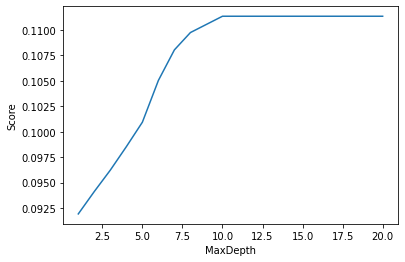

Decision tree model score: 0.08930716860232278


In [ ]:
# choose the best depth of the tree
score = []
maxDepth = 21
for i in range(1,maxDepth):

  # create and fir decision tree
  tree = DecisionTreeClassifier(random_state = 1, max_depth = i)

  tree.fit(X_train,y_train)
  score.append(tree.score(X_train,y_train))
  # print(score)

# plot results
plt.plot(range(1,maxDepth),score)
plt.xlabel('MaxDepth')
plt.ylabel('Score')
plt.show()

# train again with the best depth
bestDepth = 14
tree = DecisionTreeClassifier(max_depth = bestDepth)
tree.fit(X_train,y_train)

# see the score
print(f'Decision tree model score: {tree.score(X_test,y_test)}')

#### Random Forest Classifier

In [ ]:
# create and fit random forest
forest = RandomForestClassifier(random_state = 1,n_estimators = 200)
forest.fit(X_train,y_train)

# print feature importance and score
print(list(zip(features.columns,forest.feature_importances_)))
print(f'Random forest model score: {forest.score(X_test,y_test)}')

[('smokes', 0.3642687434894222), ('drinks', 0.43987558609198363), ('drugs', 0.19585567041859409)]
Random forest model score: 0.09090909090909091


#### XGBoost

#### Cross Validation

In [12]:
df.iloc[:,:-2]

,body_type,diet,drinks,drugs,education,job,orientation,pets,religion,sex,smokes,status,zodiac
0,a little extra,strictly anything,socially,never,working on college/university,transportation,straight,likes dogs and likes cats,agnosticism,m,sometimes,single,gemini
1,average,mostly other,often,sometimes,working on space camp,hospitality / travel,straight,likes dogs and likes cats,agnosticism,m,no,single,cancer
2,thin,anything,socially,NaN,graduated from masters program,NaN,straight,has cats,NaN,m,no,available,pisces
3,thin,vegetarian,socially,NaN,working on college/university,student,straight,likes cats,NaN,m,no,single,pisces
4,athletic,NaN,socially,never,graduated from college/university,artistic / musical / writer,straight,likes dogs and likes cats,NaN,m,no,single,aquarius
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59941,NaN,NaN,socially,never,graduated from college/university,sales / marketing / biz dev,straight,has dogs,catholicism,f,no,single,cancer
59942,fit,mostly anything,often,sometimes,working on college/university,entertainment / media,straight,likes dogs and likes cats,agnosticism,m,no,single,leo
59943,average,mostly anything,not at all,never,graduated from masters program,construction / craftsmanship,straight,NaN,christianity,m,no,single,sagittarius
59944,athletic,mostly anything,socially,often,working on college/university,medicine / health,straight,likes dogs and likes cats,agnosticism,m,trying to quit,single,leo


### Essay questions


In [122]:
df_essay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   essay0  54458 non-null  object
 1   essay1  52374 non-null  object
 2   essay2  50308 non-null  object
 3   essay3  48470 non-null  object
 4   essay4  49409 non-null  object
 5   essay5  49096 non-null  object
 6   essay6  46175 non-null  object
 7   essay7  47495 non-null  object
 8   essay8  40721 non-null  object
 9   essay9  47343 non-null  object
 10  zodiac  48890 non-null  object
dtypes: object(11)
memory usage: 5.0+ MB


In [140]:
# df_essay.zodiac.replace({'leo':0,
#                         'gemini':1,
#                         'libra':2,
#                         'cancer':3,
#                         'virgo':4,
#                         'taurus':5,
#                         'scorpio':6,
#                         'aries':7,
#                         'pisces':8,
#                         'sagittarius':9,
#                         'aquarius':10,
#                         'capricorn':11},inplace = True)

In [141]:
# from scipy.sparse import hstack

# result_matrix_train = None
# result_matrix_test = None

# print(list(X_train.columns))
# for feature_colunm_name in list(X_train.columns):
#     cv = CountVectorizer(stop_words = 'english')
#     X_train_cv = cv.fit_transform(X_train[feature_colunm_name])

#     # Merge the vector with others
#     result_matrix_train = hstack((result_matrix_train, X_train_cv)) if result_matrix_train is not None else X_train_cv

#     # Now transform the test data
#     X_test_cv = cv.transform(X_test[feature_colunm_name])
#     result_matrix_test = hstack((result_matrix_test, X_test_cv)) if result_matrix_test is not None else X_test_cv


training_vectors = None
test_vectors = None
for column in list(X_train.columns):
# bag of words
    cv = CountVectorizer()
    training_vector = pd.DataFrame(cv.fit_transform(X_train[column]))
    test_vector = pd.DataFrame(cv.transform(X_test[column]))

    training_vectors = pd.concat([training_vectors,training_vector],axis = 1) if training_vectors is not None else training_vector
    test_vectors = pd.concat([test_vectors,test_vector],axis = 1) if test_vectors is not None else test_vector
# other columns
# result_matrix_train = hstack((result_matrix_test, X_train[other_columns].values)) 
# result_matrix_test = hstack((result_matrix_test, X_test[other_columns].values)) 

# Naive Bayes Classifier
zodiac_classifier = MultinomialNB()

zodiac_classifier.fit(result_matrix_train, training_labels)

predictions = zodiac_classifier.predict(result_matrix_test)
print(predictions)
print(f'Naive Bayes model score: {zodiac_classifier.score(result_matrix_test,y_test)}')

['taurus' 'taurus' 'libra' ... 'scorpio' 'leo' 'gemini']
Naive Bayes model score: 0.08403522205206738


## Make models
 List of models
 outputs from models

evaluate models and Final model

What did you learn through the process?
Are the results what you expected?
What are the key findings/takeaways?

Are there things that shopuld be done differently?
 How can this be used in the future?
 vl